## Disentangling infection-induced changes in the single-cell atlas of the *Plasmodium* liver stage (Part I)

In this two-part tutorial, we will apply `sisPCA` (Part II) and VAE models (Part II) on a single-cell RNA-seq (scRNA-seq) dataset of mouse liver collected at different time points after malarial infection.

In Part I, we focus on linear PCA models including `PCA`, `sPCA`, and `sisPCA` for their interpretability. Specifically, we will

1. Apply PCA models to learn distinct subspaces of infection-related changes in the scRNA-seq data,
2. Find significant genes that contribute to each subspace,
3. Explore the effect of model hyperparameter `lambda_contrast` in `sisPCA`.

In [1]:
import torch
from lightning.pytorch import seed_everything

torch.set_default_dtype(torch.float32)

import numpy as np
import pandas as pd
from sklearn.metrics import silhouette_score
from scipy.linalg import subspace_angles
import matplotlib.pyplot as plt
from plotnine import *

import scanpy as sc

from sispca import Supervision, SISPCADataset, SISPCA

### Load the infection scRNA-seq anndata
The single-cell atlas of the *Plasmodium* liver stage provides the gene expression profiles of mouse hepatocytes during malaria infection [(Afriat et al. 2022)](https://www.nature.com/articles/s41586-022-05406-5). Pre-processed data can be downloaded from [figshare (from Piran et al. 2024)](https://figshare.com/articles/dataset/spatio-temporal-infection_infected/22148900?file=39375713), and the original dataset is available (as processed Seurat object) at [Zenodo](https://zenodo.org/records/7081863).

Here, we will focus on the log-normalized gene expression counts (`X`) with 19,053 cells (rows) and 8,203 genes (columns). The dataset also contains the following metadata (supervision):

- `Y_time`: the post-infection time point of the sample collection (2, 12, 24, 30 and 36h post-infection, abbreviated hpi, or 'control' for samples from control mice)
- `Y_infected`: The infection status (i.e., whether a hepatocyte contains a parasite) determined based on GFP expression linked to malaria.

The goals of this example analysis are to:

1. Learn separate subspace representations corresponding to the infection status and temporal dynamics after infection,
2. Understand how the gene expression profiles of hepatocytes contribute to infection response and dynamics.

In [2]:
data_dir = "/Volumes/JSBackup/SisPCA_oldres/data/liver_infection/"

data_infected = sc.read_h5ad(data_dir + 'adata_infected.h5ad')
data_infected

AnnData object with n_obs × n_vars = 19053 × 8203
    obs: 'barcode', 'mouse', 'marker', 'time', 'infected', 'experiment', 'coarse_time', 'MB', 'eta', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'mt_qc', 'SUMPBA', 'n_counts', 'n_genes', 'mus_rRNA', 'pba_rRNA', 'pba_rRNA_fraction', 'nCount_PBA', 'nFeature_PBA', 'nCount_MUS', 'nFeature_MUS', 'RNA_snn_res.0.2', 'seurat_clusters', 'MBinfected', 'cluster_names', 'ident', 'eta_normalized', 'nCounts_tot', 'normalized_PBA', 'coarse_time_orig', 'zone', 'status', 'status_control', 'time_int', 'split_random'
    var: 'org', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'coarse_time_colors', 'hvg', 'log1p', 'neighbors', 'pca', 'status_colors', 'status_control_colors', 'umap', 'zone_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts', 'logcounts', 'scaledata'
    obsp: 'connectivities', 'distances'

In [3]:
y_time = data_infected.obs['coarse_time'].cat.codes.to_numpy()[:, None]
y_infected = data_infected.obs['infected'].cat.codes.to_numpy()[:, None]

Let's take a look at the structure of the dataset. Visually we can that the PCA (and UMAP) space contain multiple sources of variation, including the infection status, the time point of the sample collection, and cell intrinsic qualities.

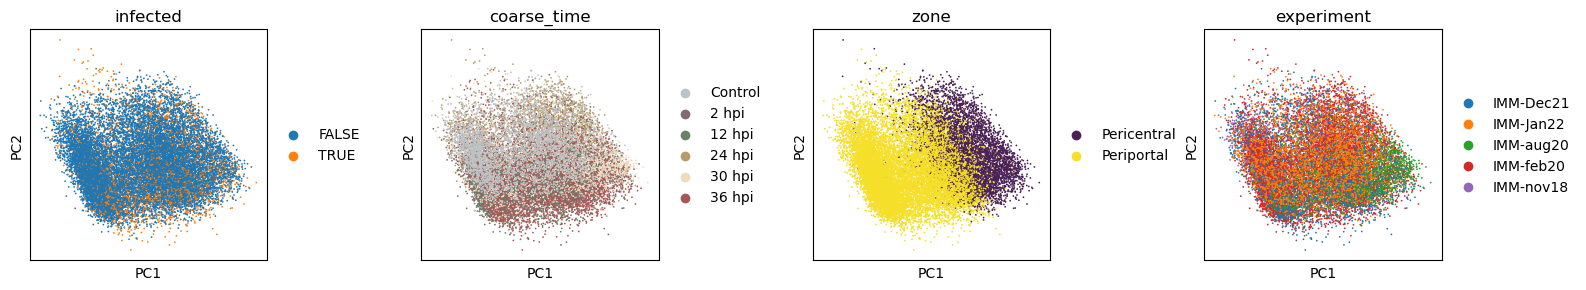

In [4]:
with plt.rc_context({"figure.figsize": (3, 3)}):
    sc.pl.pca(data_infected, color = ['infected', 'coarse_time', 'zone', 'experiment'], wspace=0.5)

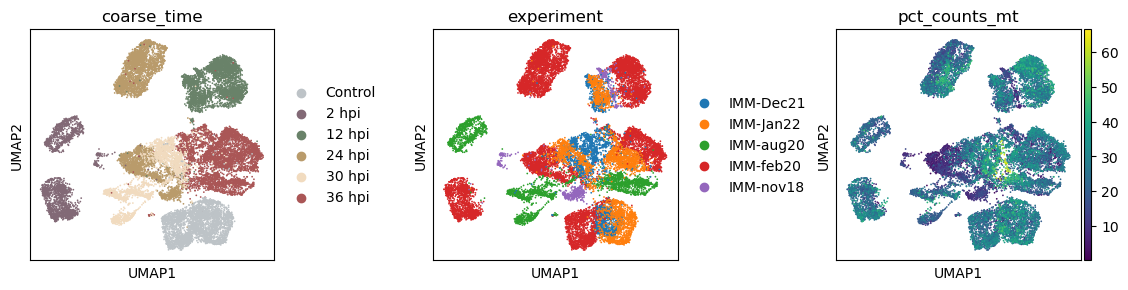

In [5]:
with plt.rc_context({"figure.figsize": (3, 3)}):
    sc.pl.umap(data_infected, color = ['coarse_time', 'experiment', 'pct_counts_mt'], wspace = 0.5)

Before running the PCA and VAE models, the common practice in single-cell analysis is to reduce the number of features (genes) by selecting the most variable genes. Here, we will use the `scanpy.pp.highly_variable_genes` function to select the top 2,000 highly variable genes.

In [6]:
adata = data_infected.copy()

# keep highly variable genes
sc.pp.highly_variable_genes(adata, layer='logcounts', n_top_genes=2000, subset=True)

adata.shape

(19053, 2000)

### Overview of PCA-based linear models

In the next section, we will apply PCA-based linear models to the same dataset.

- `PCA`: The vanilla unsupervised PCA model that learns a single subpace.
- `sPCA`: Supervised PCA where subspaces are aligned to target variables via HSIC maximization.
- `sisPCA`: Supervised independent subspace PCA that introduces additional HSIC regularization to enforce subspace disentanglement.

We will be using the `sispca.SISPCA` class for all models. Let's first prepare model inputs.

In [7]:
logcounts = torch.tensor(adata.layers['logcounts'].toarray())
y_infected = adata.obs['infected'].cat.codes.to_numpy()[:, None]
y_time = adata.obs['coarse_time'].cat.codes.to_numpy()[:, None]

### Run PCA (no supervision, no HSIC)

Let's start with the vanilla `PCA` model.

In [8]:
# specify the configuration
sdata = SISPCADataset(data = logcounts.float(), target_supervision_list = [])
n_latent_sub = [10]
lambda_contrast = 0
kernel_subspace = 'linear'
solver = 'eig'

seed_everything(42, workers=True)

# initialize the model
pca = SISPCA(
    dataset = sdata,
    n_latent_sub = n_latent_sub,
    lambda_contrast = lambda_contrast,
    kernel_subspace = kernel_subspace,
    solver = solver,
)

Seed set to 42


0 supervision variables provided for 1 subspaces. The last subspace will be unsupervised.


#### Model fitting

In [9]:
# running PCA using all data
pca.fit(max_epochs = 2, batch_size = -1, shuffle = True, early_stopping_patience = 3, lr = 1)

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/jysumac/miniforge3/envs/sispca/lib/python3.10/site-packages/lightning/pytorch/trainer/setup.py:177: PossibleUserWarning: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/Users/jysumac/miniforge3/envs/sispca/lib/python3.10/site-packages/lightning/pytorch/core/optimizer.py:182: UserWarning: `LightningModule.configure_optimizers` returned `None`, this fit will run with no optimizer

  | Name         | Type | Params | Mode
---------------------------------------------
  | other params | n/a  | 20.0 K | n/a 
---------------------------------------------
0         Trainable params
20.0 K    Non-trainable params
20.0 K    Total params
0.080     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode
/Users/jysumac/miniforge3/envs/sispca/lib/python3.10/site-packages/lightning/pytorch/trainer/co

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=2` reached.



Solving the PCA involves the SVD computation of the gram matrix of all data. However, since the project of interest `U` is of size (n_feature, n_latent), which is independent of n_sample, in practice we may not need to load all data into memory for the SVD. Here we implement naive mini-batching through `lightning`. This approach is more memory-efficient albeit stochastic compared to the exact PCA. By default, we set `lr = 1`, which is equivalent to subsampling the data to `n_sample = batch_size` and using the SVD of the subset. In the future, we plan to support incremental SVD update methods to further speed up the convergence.

In [10]:
# # running (approximate) PCA using 5,000 cells, more memory efficient but may not converge
# pca.fit(max_epochs = 3, batch_size = 5000, shuffle = True, early_stopping_patience = 3, lr = 1)

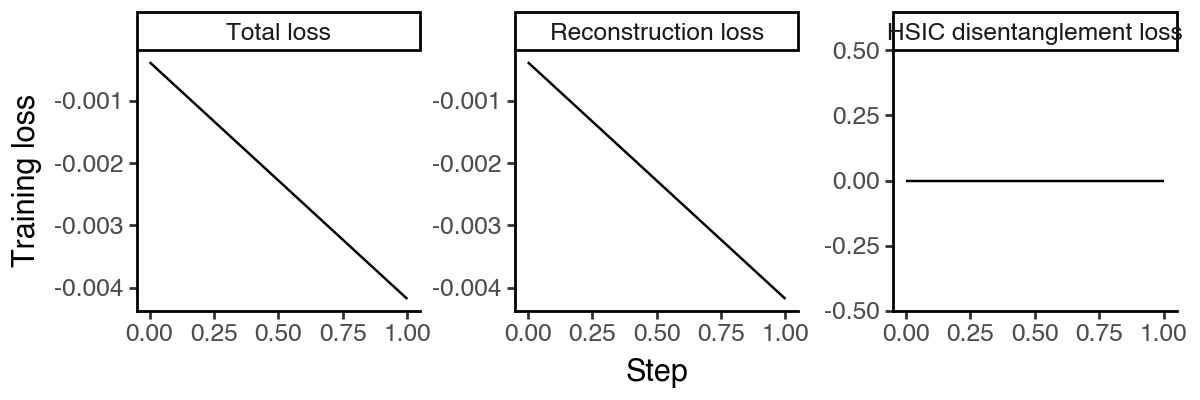

In [11]:
df_loss = pd.DataFrame(
    {k:pca.history[k]
     for k in ['train_loss_step', 'reg_loss_step']}
).reset_index(names='step')
df_loss['recon_loss_step'] = df_loss['train_loss_step'] - df_loss['reg_loss_step']

df_loss = df_loss.melt(id_vars='step', var_name='loss_type', value_name='loss')
df_loss['loss_type'] = pd.Categorical(
    df_loss['loss_type'].map({
        'train_loss_step': 'Total loss',
        'recon_loss_step': 'Reconstruction loss',
        'reg_loss_step': 'HSIC disentanglement loss',
    }),
    categories=['Total loss', 'Reconstruction loss', 'HSIC disentanglement loss'],
    ordered=True
)

(
    ggplot(df_loss, aes(x = 'step', y = 'loss', group = 'loss_type')) +
        facet_wrap('~loss_type', scales='free_y', ncol = 3) +
        geom_line() +
        labs(x = 'Step', y = 'Training loss') +
        theme_classic() +
        theme(figure_size=(6,2))
)

#### Visualize the latent space

Now let's extract the learned latent subspace and use UMAP to visualize it. We can see that the PCA space mainly captures the temporal dynamics post infection.

In [12]:
_method = 'pca'
adata.obsm[f'X_{_method}'] = pca.get_latent_representation()

# add the latent representation to the adata object
_sub = np.split(adata.obsm[f'X_{_method}'], n_latent_sub[:-1], axis = -1)
for i in range(len(_sub)):
    adata.obsm[f'X_{_method}_{i+1}'] = _sub[i]

# project the latent subspaces to 2D using UMAP
for i in range(len(_sub)):
    sc.pp.neighbors(adata, use_rep=f"X_{_method}_{i+1}")
    sc.tl.umap(adata)
    adata.obsm[f'X_umap_{_method}_{i + 1}'] = adata.obsm['X_umap'].copy()

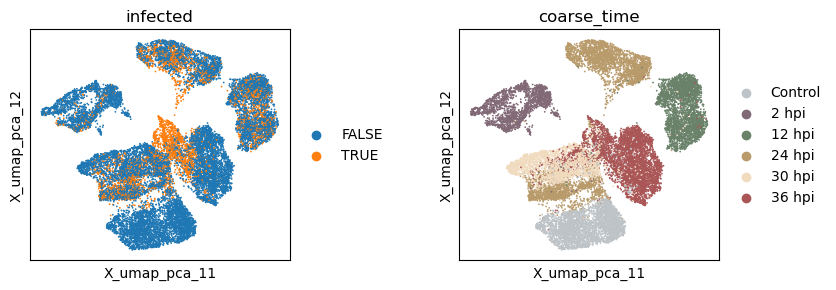

In [13]:
with plt.rc_context({"figure.figsize": (3, 3)}):
    sc.pl.embedding(adata, basis=f'X_umap_{_method}_1', color=['infected', 'coarse_time'], ncols=2, wspace = 0.5)

#### Evaluate the quality of learned subspace representations

Since we are only learning one subspace, there is no disentanglement as can be measured by the Grassmann distance.

In [14]:
_method = 'pca'

# subspace grassmann distance
np.linalg.norm(subspace_angles(adata.obsm[f'X_{_method}'], adata.obsm[f'X_{_method}']))

np.float32(6.6312223e-06)

To measure the information density of the learned subspace, we use the silhouette score where a high value indicates that the target information is well-presented in the corresponding subspace. Because PCA dimensions are ordered by variance and we know exactly the effective dimensions (i.e. the number of groups) of each target subspace, we will focus on the first `n_effective` dimensions for each target subspace. Using all dimensions will yield similar results since the extra dimensions would have near-zero scales. From the results we see again that the unsupervised PCA embeddings mostly captures the temporal dynamics rather than the infection status.

In [15]:
_method = 'pca'

# raw embeddings
f1 = silhouette_score(
    adata.obsm[f'X_{_method}'][:, :2], 
    y_infected.squeeze()
)
f2 = silhouette_score(
    adata.obsm[f'X_{_method}'][:, :6], 
    y_time.squeeze()
)

print(f"Information density - Silhouette - (infection, time): ({f1:.3f}, {f2:.3f})")

# UMAP embeddings
f3 = silhouette_score(
    adata.obsm[f'X_umap_{_method}_1'], 
    y_infected.squeeze()
)
f4 = silhouette_score(
    adata.obsm[f'X_umap_{_method}_1'], 
    y_time.squeeze()
)

print(f"Information density after UMAP - Silhouette - (infection, time): ({f3:.3f}, {f4:.3f})")

Information density - Silhouette - (infection, time): (0.030, 0.094)
Information density after UMAP - Silhouette - (infection, time): (-0.009, 0.313)


### Run sPCA (with supervision, no HSIC regularization)

We next consider the supervised PCA model `sPCA` where each subspace will be aligned to the target variable `Y_infected` and `Y_time`.

In [16]:
# specify the configuration
sdata = SISPCADataset(
    data = logcounts.float(),
    target_supervision_list = [
        Supervision(target_data = y_infected, target_type = 'categorical', target_name = 'infection'),
        Supervision(target_data = y_time, target_type = 'categorical', target_name = 'time'),
    ]
)
n_latent_sub = [10, 10]
lambda_contrast = 0
kernel_subspace = 'linear'
solver = 'eig'

seed_everything(42, workers=True)

# initialize the model
spca = SISPCA(
    dataset = sdata,
    n_latent_sub = n_latent_sub,
    lambda_contrast = lambda_contrast,
    kernel_subspace = kernel_subspace,
    solver = solver,
)

/Users/jysumac/Projects/sispca/sispca/data.py:60: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_numpy.cpp:212.)
Seed set to 42


#### Model fitting

In [17]:
# running sPCA using all data
spca.fit(max_epochs = 3, batch_size = -1, shuffle = True, early_stopping_patience = 3, lr = 1)

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/jysumac/miniforge3/envs/sispca/lib/python3.10/site-packages/lightning/pytorch/trainer/setup.py:177: PossibleUserWarning: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/Users/jysumac/miniforge3/envs/sispca/lib/python3.10/site-packages/lightning/pytorch/core/optimizer.py:182: UserWarning: `LightningModule.configure_optimizers` returned `None`, this fit will run with no optimizer

  | Name         | Type | Params | Mode
---------------------------------------------
  | other params | n/a  | 40.0 K | n/a 
---------------------------------------------
0         Trainable params
40.0 K    Non-trainable params
40.0 K    Total params
0.160     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode
/Users/jysumac/miniforge3/envs/sispca/lib/python3.10/site-packages/lightning/pytorch/trainer/co

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=3` reached.


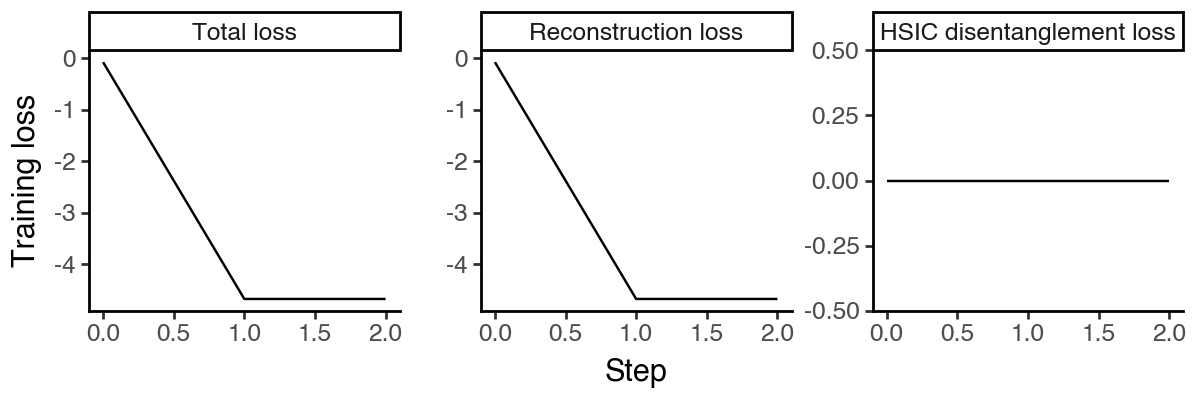

In [18]:
df_loss = pd.DataFrame(
    {k:spca.history[k]
     for k in ['train_loss_step', 'reg_loss_step']}
).reset_index(names='step')
df_loss['recon_loss_step'] = df_loss['train_loss_step'] - df_loss['reg_loss_step']

df_loss = df_loss.melt(id_vars='step', var_name='loss_type', value_name='loss')
df_loss['loss_type'] = pd.Categorical(
    df_loss['loss_type'].map({
        'train_loss_step': 'Total loss',
        'recon_loss_step': 'Reconstruction loss',
        'reg_loss_step': 'HSIC disentanglement loss',
    }),
    categories=['Total loss', 'Reconstruction loss', 'HSIC disentanglement loss'],
    ordered=True
)

(
    ggplot(df_loss, aes(x = 'step', y = 'loss', group = 'loss_type')) +
        facet_wrap('~loss_type', scales='free_y', ncol = 3) +
        geom_line() +
        labs(x = 'Step', y = 'Training loss') +
        theme_classic() +
        theme(figure_size=(6,2))
)

#### Visualize the latent spaces

Now let's extract the learned latent subspaces and use UMAP to visualize them. Already, by maximizing the HSIC between the infection subspace and the target variable, we get a better separation of the infected and uninfected cells. Still, the time subspace retains part of the infection status information, which may bias the downstream analysis.

In [19]:
_method = 'spca'
adata.obsm[f'X_{_method}'] = spca.get_latent_representation()

# add the latent representation to the adata object
_sub = np.split(adata.obsm[f'X_{_method}'], n_latent_sub[:-1], axis = -1)
for i in range(len(_sub)):
    adata.obsm[f'X_{_method}_{i+1}'] = _sub[i]

# project the latent subspaces to 2D using UMAP
for i in range(len(_sub)):
    sc.pp.neighbors(adata, use_rep=f"X_{_method}_{i + 1}")
    sc.tl.umap(adata)
    adata.obsm[f'X_umap_{_method}_{i + 1}'] = adata.obsm['X_umap'].copy()

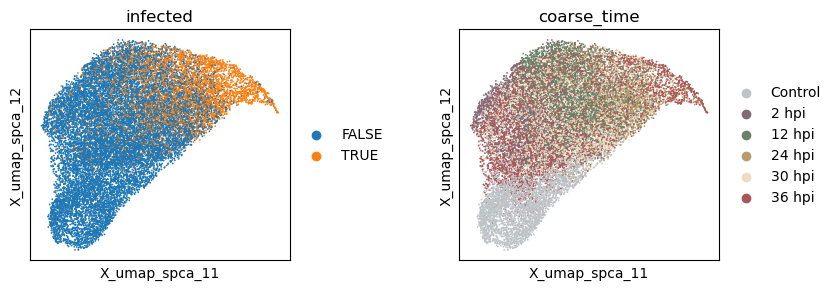

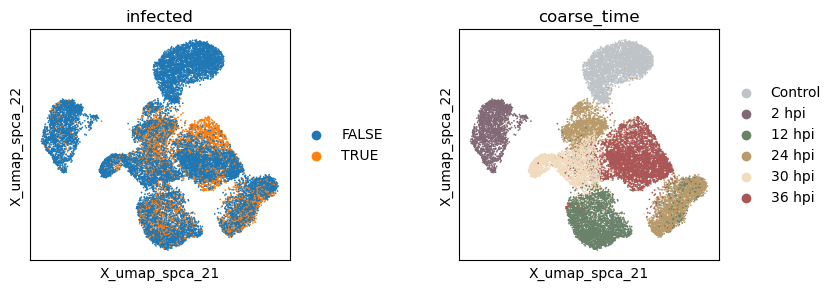

In [20]:
with plt.rc_context({"figure.figsize": (3, 3)}):
    sc.pl.embedding(adata, basis=f'X_umap_{_method}_1', color=['infected', 'coarse_time'], ncols=2, wspace = 0.5)
    sc.pl.embedding(adata, basis=f'X_umap_{_method}_2', color=['infected', 'coarse_time'], ncols=2, wspace = 0.5)

#### Evaluate the quality of learned subspace representations

We can again measure the subspace separateness using Grassmann distance and the information density using the silhouette score. The quantitative results confirm that HSIC maximization is an effective way to impose supervision.

In [21]:
_method = 'spca'

# subspace grassmann distance
np.linalg.norm(subspace_angles(adata.obsm[f'X_{_method}_1'], adata.obsm[f'X_{_method}_2']))

np.float32(3.8208525)

In [22]:
_method = 'spca'

# raw embeddings
f1 = silhouette_score(
    adata.obsm[f'X_{_method}_1'][:, :2], 
    y_infected.squeeze()
)
f2 = silhouette_score(
    adata.obsm[f'X_{_method}_2'][:, :6], 
    y_time.squeeze()
)

print(f"Information density - Silhouette - (infection, time): ({f1:.3f}, {f2:.3f})")

# UMAP embeddings
f3 = silhouette_score(
    adata.obsm[f'X_umap_{_method}_1'], 
    y_infected.squeeze()
)
f4 = silhouette_score(
    adata.obsm[f'X_umap_{_method}_2'], 
    y_time.squeeze()
)

print(f"Information density after UMAP - Silhouette - (infection, time): ({f3:.3f}, {f4:.3f})")

Information density - Silhouette - (infection, time): (0.276, 0.298)
Information density after UMAP - Silhouette - (infection, time): (0.199, 0.363)


### Run sisPCA (with supervision, with HSIC regularization)

Finally, let's run the supervised independent subspace PCA model `sisPCA` where subspaces are further disentangled via an extra HSIC regularization.

In [23]:
# specify the configuration
sdata = SISPCADataset(
    data = logcounts.float(),
    target_supervision_list = [
        Supervision(target_data = y_infected, target_type = 'categorical', target_name = 'infection'),
        Supervision(target_data = y_time, target_type = 'categorical', target_name = 'time'),
    ]
)
n_latent_sub = [10, 10]
lambda_contrast = 10
kernel_subspace = 'linear'
solver = 'eig'

seed_everything(42, workers=True)

# initialize the model
sispca = SISPCA(
    dataset = sdata,
    n_latent_sub = n_latent_sub,
    lambda_contrast = lambda_contrast,
    kernel_subspace = kernel_subspace,
    solver = solver,
)

Seed set to 42


#### Model fitting

The computational bottleneck of sisPCA-linear is the multiple rounds of eigen-decomposition of a matrix of size (n_feature, n_feature). In the future, we may support randomized SVD to further speed up the computation.

In [24]:
# running sisPCA using all data
sispca.fit(max_epochs = 20, batch_size = -1, shuffle = True, early_stopping_patience = 5, lr = 1)

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/jysumac/miniforge3/envs/sispca/lib/python3.10/site-packages/lightning/pytorch/trainer/setup.py:177: PossibleUserWarning: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/Users/jysumac/miniforge3/envs/sispca/lib/python3.10/site-packages/lightning/pytorch/core/optimizer.py:182: UserWarning: `LightningModule.configure_optimizers` returned `None`, this fit will run with no optimizer

  | Name         | Type | Params | Mode
---------------------------------------------
  | other params | n/a  | 40.0 K | n/a 
---------------------------------------------
0         Trainable params
40.0 K    Non-trainable params
40.0 K    Total params
0.160     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode
/Users/jysumac/miniforge3/envs/sispca/lib/python3.10/site-packages/lightning/pytorch/trainer/co

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=20` reached.


In most cases, the memory usage scales linearly with n_samples. To further reduce memory usage, we provide minibatch training as an experimental feature, which is more memory-efficient albeit stochastic and may not converge in some cases. We plan to support incremental SVD update methods in the future.

In [25]:
# # running sisPCA using 5,000 cells, can further reduce memory usage but may not converge
# sispca.fit(max_epochs = 20, batch_size = 5000, shuffle = True, early_stopping_patience = 5, lr = 1)

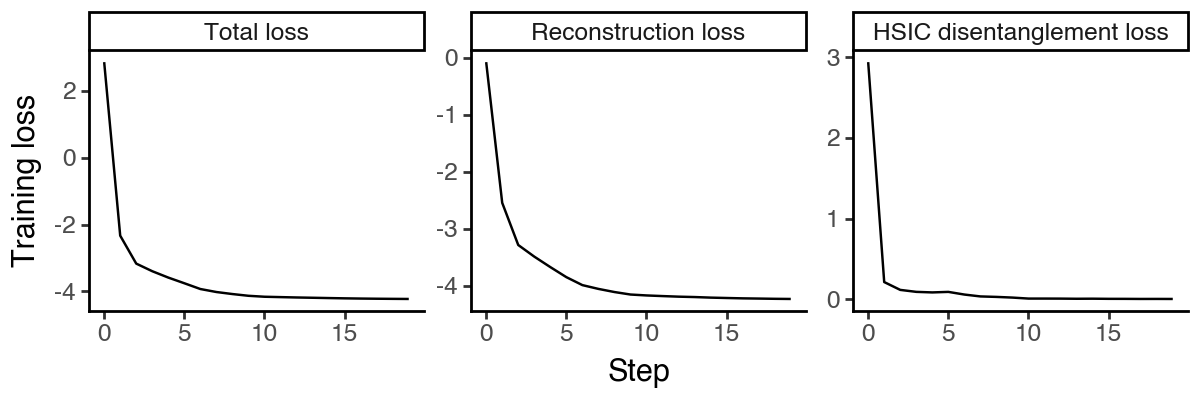

In [26]:
df_loss = pd.DataFrame(
    {k:sispca.history[k]
     for k in ['train_loss_step', 'reg_loss_step']}
).reset_index(names='step')
df_loss['recon_loss_step'] = df_loss['train_loss_step'] - df_loss['reg_loss_step']

df_loss = df_loss.melt(id_vars='step', var_name='loss_type', value_name='loss')
df_loss['loss_type'] = pd.Categorical(
    df_loss['loss_type'].map({
        'train_loss_step': 'Total loss',
        'recon_loss_step': 'Reconstruction loss',
        'reg_loss_step': 'HSIC disentanglement loss',
    }),
    categories=['Total loss', 'Reconstruction loss', 'HSIC disentanglement loss'],
    ordered=True
)

(
    ggplot(df_loss, aes(x = 'step', y = 'loss', group = 'loss_type')) +
        facet_wrap('~loss_type', scales='free_y', ncol = 3) +
        geom_line() +
        labs(x = 'Step', y = 'Training loss') +
        theme_classic() +
        theme(figure_size=(6,2))
)

#### Visualize the latent spaces

Now let's extract the learned latent subspaces and use UMAP to visualize them.

In [27]:
_method = 'sispca'
adata.obsm[f'X_{_method}'] = sispca.get_latent_representation()

# add the latent representation to the adata object
_sub = np.split(adata.obsm[f'X_{_method}'], n_latent_sub[:-1], axis = -1)
for i in range(len(_sub)):
    adata.obsm[f'X_{_method}_{i+1}'] = _sub[i]

# project the latent subspaces to 2D using UMAP
for i in range(len(_sub)):
    sc.pp.neighbors(adata, use_rep=f"X_{_method}_{i + 1}")
    sc.tl.umap(adata)
    adata.obsm[f'X_umap_{_method}_{i + 1}'] = adata.obsm['X_umap'].copy()

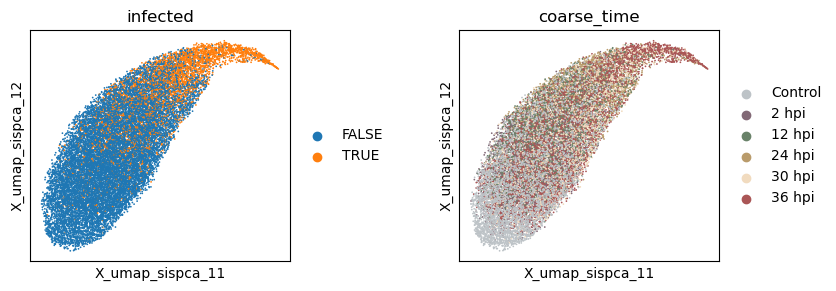

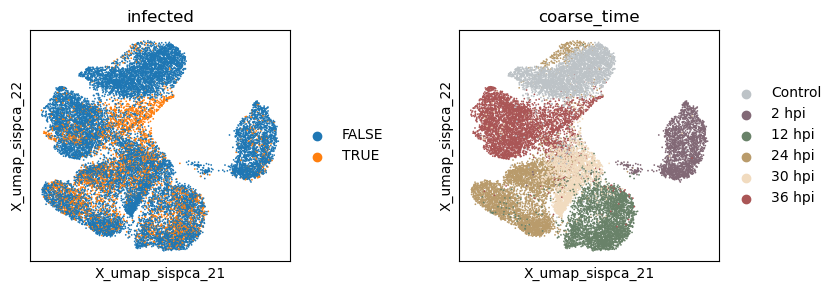

In [28]:
with plt.rc_context({"figure.figsize": (3, 3)}):
    sc.pl.embedding(adata, basis=f'X_umap_{_method}_1', color=['infected', 'coarse_time'], ncols=2, wspace = 0.5)
    sc.pl.embedding(adata, basis=f'X_umap_{_method}_2', color=['infected', 'coarse_time'], ncols=2, wspace = 0.5)

#### Evaluate the quality of learned subspace representations

In [29]:
_method = 'sispca'

# subspace grassmann distance
np.linalg.norm(subspace_angles(adata.obsm[f'X_{_method}_1'], adata.obsm[f'X_{_method}_2']))

np.float32(4.965978)

In [30]:
_method = 'sispca'

# raw embeddings
f1 = silhouette_score(
    adata.obsm[f'X_{_method}_1'][:, :2], 
    y_infected.squeeze()
)
f2 = silhouette_score(
    adata.obsm[f'X_{_method}_2'][:, :6], 
    y_time.squeeze()
)

print(f"Information density - Silhouette - (infection, time): ({f1:.3f}, {f2:.3f})")

# UMAP embeddings
f3 = silhouette_score(
    adata.obsm[f'X_umap_{_method}_1'], 
    y_infected.squeeze()
)
f4 = silhouette_score(
    adata.obsm[f'X_umap_{_method}_2'], 
    y_time.squeeze()
)

print(f"Information density after UMAP - Silhouette - (infection, time): ({f3:.3f}, {f4:.3f})")

Information density - Silhouette - (infection, time): (0.325, 0.271)
Information density after UMAP - Silhouette - (infection, time): (0.235, 0.348)


### Model interpretation

Now let's try to understand what our `sisPCA` model has learned about the single-cell data. We will first extract the significant genes that contribute to each subspace. One key advantage of linear models like PCA is that the observed features (genes) are directly linked to dimensions in the latent space, which is specified by the learned loading matrix `U`. Using the projection as feature importance, we can rank and identify the top genes that contribute to the infection subspace (i.e. responding to parasite harboring) and the time subspace (i.e. relating to the post infection dynamics).

#### Find genes of the direct response to physical parasite harboring

Here, we focus on the PC1 of the infection subspace as an example. From the plot, we see that infected cells have higher PC1 scores.

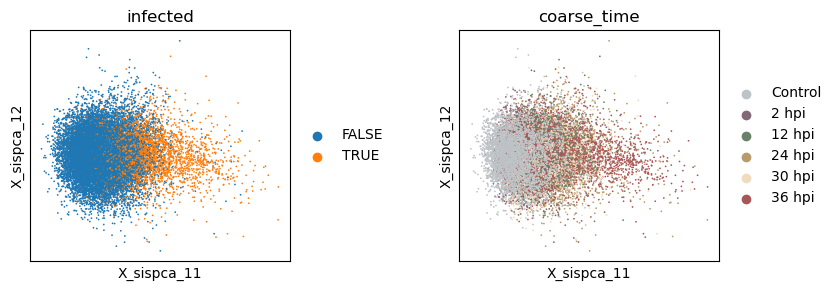

In [31]:
with plt.rc_context({"figure.figsize": (3, 3)}):
    sc.pl.embedding(adata, basis=f'X_sispca_1', color=['infected', 'coarse_time'], ncols=2, wspace = 0.5)

Now let's find top genes that positively and negatively contribute to PC1 of the infection subspace.

In [32]:
gene_weights, gene_idx = torch.sort(sispca.U[:,0].detach(), descending = True)
gene_names_top100_pos = adata.var.index[gene_idx[:100]].to_list()
gene_names_top100_neg = adata.var.index[gene_idx[-100:]].to_list()

print(f"Top 5 genes positively weighted (higher in infected cells): {gene_names_top100_pos[:5]}")
print(f"Top 5 genes negatively weighted (lower in infected cells): {gene_names_top100_neg[:5]}")

Top 5 genes positively weighted (higher in infected cells): ['Gstm3', 'Gsta1', 'Gstp1', 'Rsad2', 'Cyp2a5']
Top 5 genes negatively weighted (lower in infected cells): ['Cmbl', 'Etnk2', 'Acaa1b', 'Insig1', 'Tkfc']


#### Gene Ontology enrichment analysis

We can further perform gene ontology (GO) enrichment analysis to understand the biological functions associated with the top genes. To run this step you will need to have the [gprofiler package](https://pypi.org/project/gprofiler-official/) installed.

In [33]:
df_go_pos = sc.queries.enrich(
    gene_names_top100_pos, 
    org="mmusculus", 
    gprofiler_kwargs = {'sources': ['GO:BP']}
)
df_go_neg = sc.queries.enrich(
    gene_names_top100_neg, 
    org="mmusculus", 
    gprofiler_kwargs = {'sources': ['GO:BP']}
)

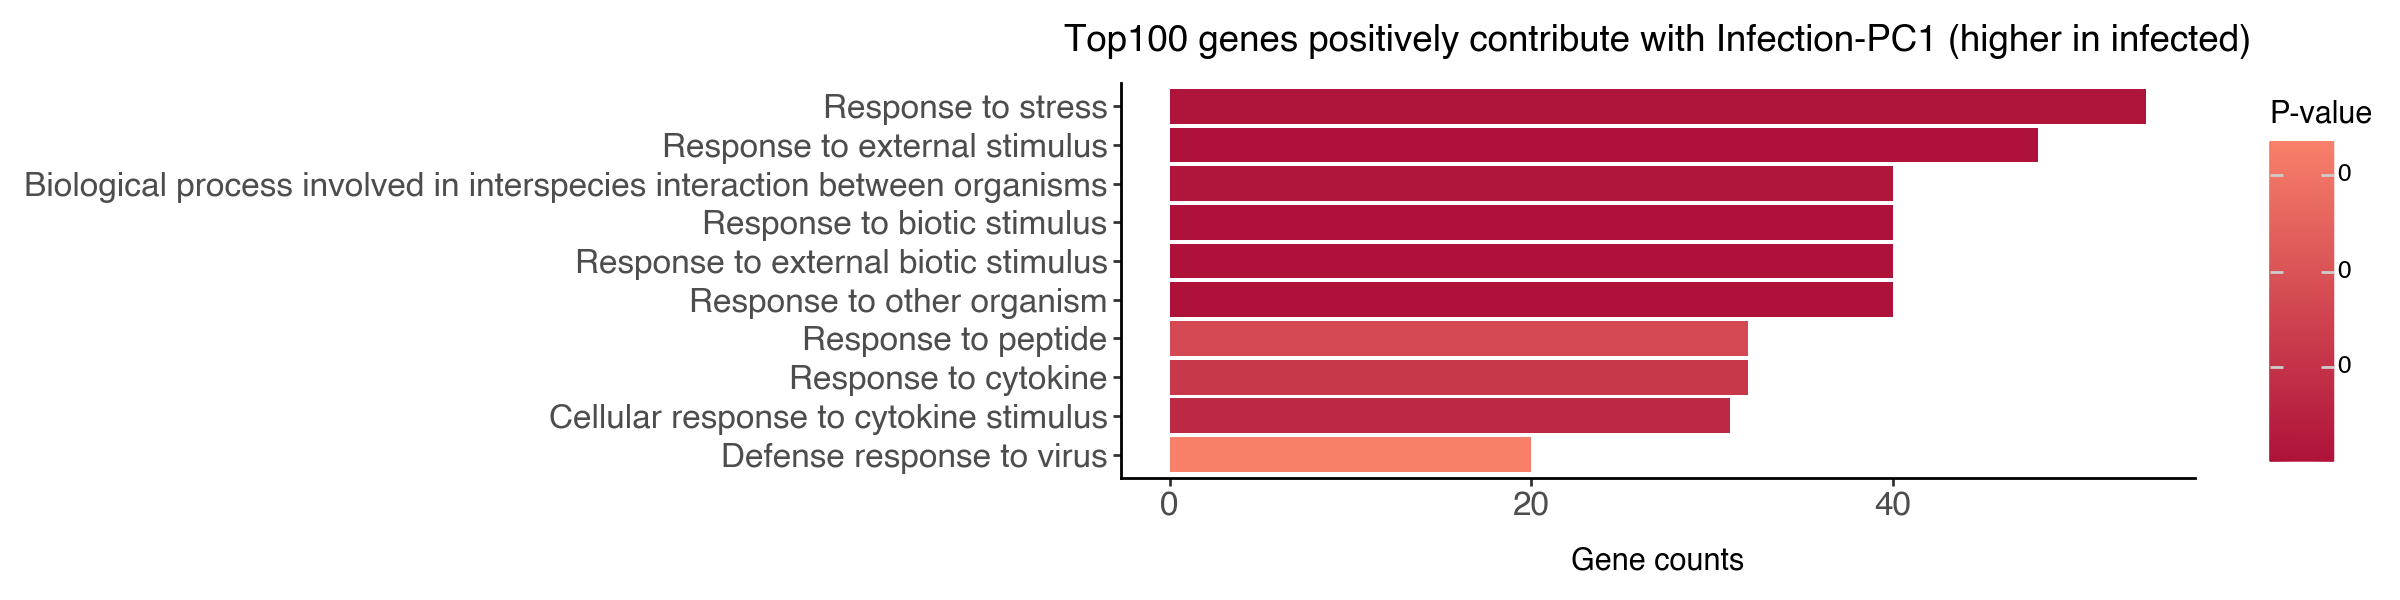

In [34]:
df_go_vis = df_go_pos.iloc[:10,:].sort_values('intersection_size', ascending=True)
df_go_vis['name'] = df_go_vis['name'].str.capitalize()
df_go_vis['name'] = df_go_vis['name'].astype('category').cat.reorder_categories(df_go_vis['name'])

(
    ggplot(df_go_vis, aes(y = 'intersection_size', x = 'name', fill = 'p_value')) +
        geom_bar(stat='identity') + 
        labs(y = 'Gene counts', x = '', fill = 'P-value', title = 'Top100 genes positively contribute with Infection-PC1 (higher in infected)') +
        scale_fill_gradient(low = "#AE123A", high = "#F8806A") + 
        coord_flip() +
        theme_classic() + 
        theme(figure_size=(12,3), axis_text=element_text(size = 12))
)



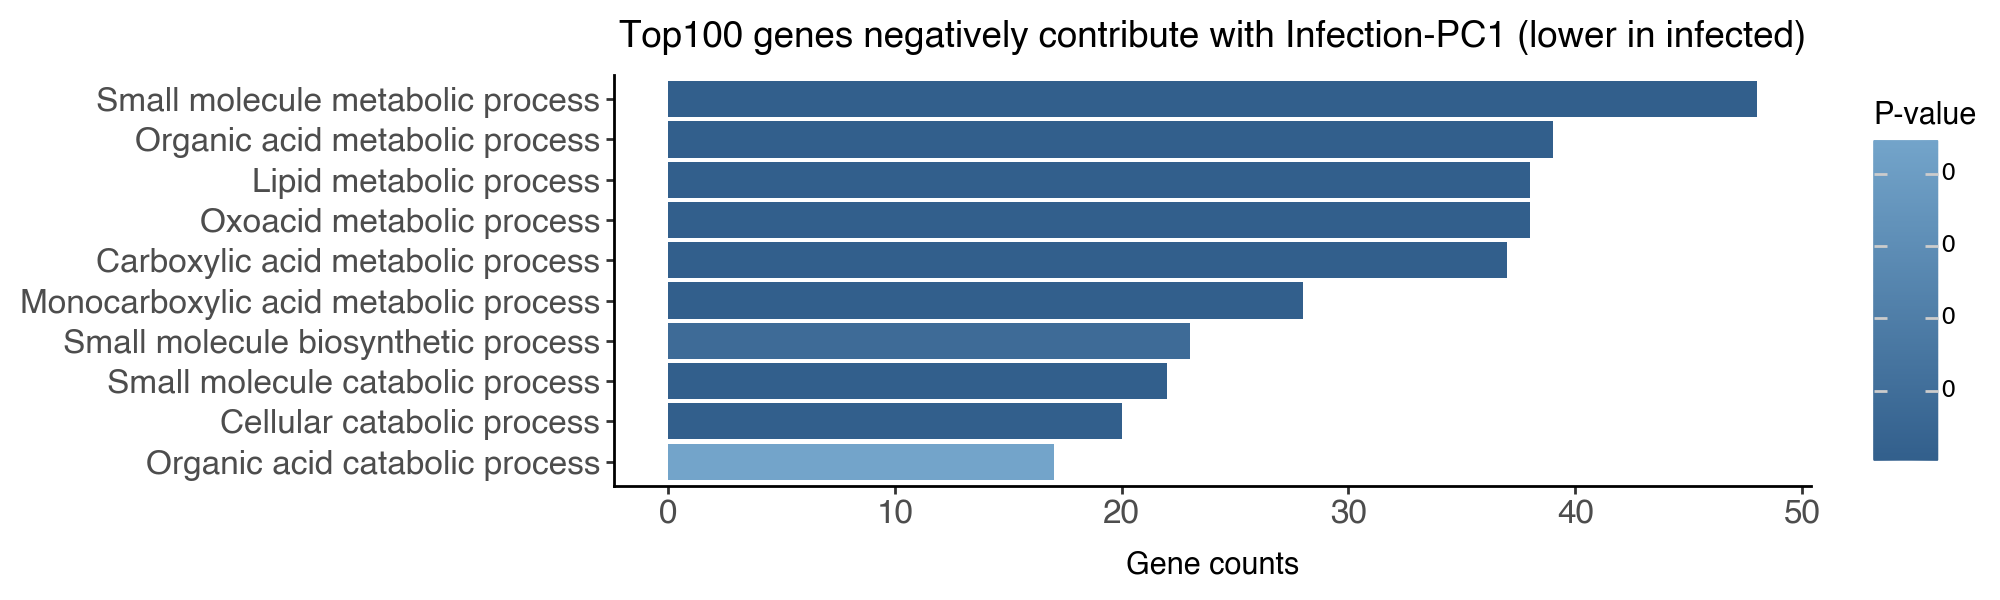

In [35]:

df_go_vis = df_go_neg.iloc[:10,:].sort_values('intersection_size', ascending=True)
df_go_vis['name'] = df_go_vis['name'].str.capitalize()
df_go_vis['name'] = df_go_vis['name'].astype('category').cat.reorder_categories(df_go_vis['name'])

(
    ggplot(df_go_vis, aes(y = 'intersection_size', x = 'name', fill = 'p_value')) +
        geom_bar(stat='identity') + 
        labs(y = 'Gene counts', x = '', fill = 'P-value', title = 'Top100 genes negatively contribute with Infection-PC1 (lower in infected)') +
        scale_fill_gradient(high = "#73A4CA", low = "#325F8C") + 
        coord_flip() +
        theme_classic() + 
        theme(figure_size=(10,3), axis_text=element_text(size = 12))
)

### Conclusions

In the first part of this tutorial, we have applied three linear models, namely `PCA`, `sPCA`, and `sisPCA`, to learn infection-related representations in the single-cell atlas of malaria liver stage. We will compare the results with non-linear counterparts in Part II.

Key takeaways:
* Maximizing HSIC against target variables is an effective way to impose supervision and guide the learning of relevant subspaces.
* `sisPCA` encourages subspace disentanglement and thus ensure minimal confounding effects.
* `sisPCA` representations are directly interpretable. 

On the biological side, we have identified genes that respond to parasite harboring and post-infection dynamics. We found that upon the physical presence of parasites, the hepatocytes respond by upregulating genes related to stress and chemical response and downregulating genes related to metabolic processes.

#### Save and reload the resulting anndata with subspace representations

In [36]:
res_dir = '/Volumes/JSBackup/SisPCA_oldres/results/liver/'
date = '0227'

adata.write_h5ad(f"{res_dir}/2k_pca_repr_{date}.h5ad")

In [37]:
res_dir = '/Volumes/JSBackup/SisPCA_oldres/results/liver/'
date = '0227'

adata = sc.read_h5ad(f"{res_dir}/2k_pca_repr_{date}.h5ad")

#### Visualize all embedding space

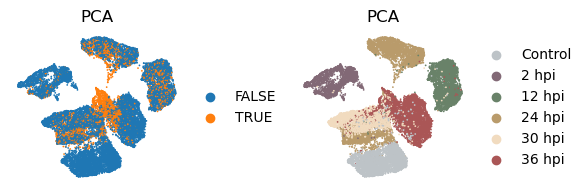

In [38]:
_method = 'pca'
with plt.rc_context({"figure.figsize": (2, 2)}):
    sc.pl.embedding(
        adata, basis=f'X_umap_{_method}_1', 
        color=['infected', 'coarse_time'], 
        title = ['PCA', 'PCA'],
        ncols=2, wspace = 0.5, frameon=False
    )

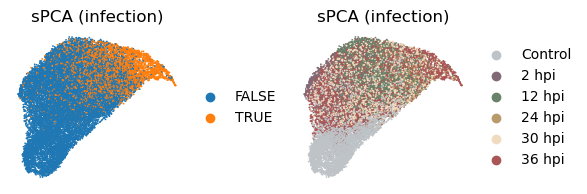

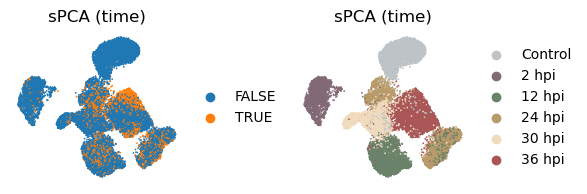

In [39]:
_method = 'spca'
with plt.rc_context({"figure.figsize": (2, 2)}):
    sc.pl.embedding(
        adata, basis=f'X_umap_{_method}_1', 
        color=['infected', 'coarse_time'], 
        title = ['sPCA (infection)', 'sPCA (infection)'],
        ncols=2, wspace = 0.5, frameon=False
    )
    sc.pl.embedding(
        adata, basis=f'X_umap_{_method}_2', 
        color=['infected', 'coarse_time'], 
        title = ['sPCA (time)', 'sPCA (time)'],
        ncols=2, wspace = 0.5, frameon=False
    )

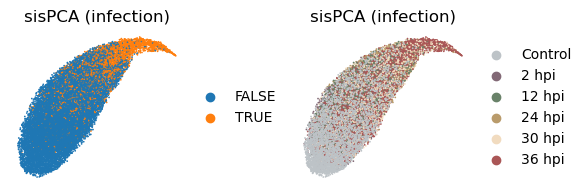

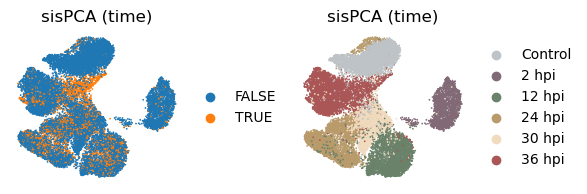

In [40]:
_method = 'sispca'
with plt.rc_context({"figure.figsize": (2, 2)}):
    sc.pl.embedding(
        adata, basis=f'X_umap_{_method}_1', 
        color=['infected', 'coarse_time'], 
        title = ['sisPCA (infection)', 'sisPCA (infection)'],
        ncols=2, wspace = 0.5, frameon=False
    )
    sc.pl.embedding(
        adata, basis=f'X_umap_{_method}_2', 
        color=['infected', 'coarse_time'], 
        title = ['sisPCA (time)', 'sisPCA (time)'],
        ncols=2, wspace = 0.5, frameon=False
    )

### Automatic hyperparameter tuning for sisPCA (experimental)
In this section, we will demonstrate how to automatically tune the hyperparameter `lambda_contrast` using spectral clustering.

In [41]:
from sispca.model import SISPCAAuto

#### Running the model with multiple scales of disentanglement penalty

Running `SISPCAAuto` would be similar to `SISPCA` but instead of providing a fixed `lambda_contrast`, we will fit with a range of values and cluster the learned latent space to get the most representative parameter.

In [42]:
# specify the configuration
sdata = SISPCADataset(
    data = logcounts.float(),
    target_supervision_list = [
        Supervision(target_data = y_infected, target_type = 'categorical', target_name = 'infection'),
        Supervision(target_data = y_time, target_type = 'categorical', target_name = 'time'),
    ]
)
n_latent_sub = [10, 10]
kernel_subspace = 'linear'
solver = 'eig'
target_sdim_list = [2, 6]

seed_everything(42, workers=True)

# initialize the model
sispca_auto = SISPCAAuto(
    sdata, 
    n_latent_sub=n_latent_sub, 
    max_log_lambda_c = 2, # maxmium log10(lambda_contrast)
    n_lambda = 10, # number of lambda_contrast values to search
    n_lambda_clu = 3, # number of lambda_contrast clusters to return
    kernel_subspace=kernel_subspace,
    solver=solver,
    target_sdim_list=target_sdim_list,
)

Seed set to 42


In [43]:
# fit the model
sispca_auto.fit(max_epochs = 20, batch_size = -1, shuffle = True, early_stopping_patience = 5, lr = 1)

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/jysumac/miniforge3/envs/sispca/lib/python3.10/site-packages/lightning/pytorch/trainer/setup.py:177: PossibleUserWarning: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/Users/jysumac/miniforge3/envs/sispca/lib/python3.10/site-packages/lightning/pytorch/core/optimizer.py:182: UserWarning: `LightningModule.configure_optimizers` returned `None`, this fit will run with no optimizer

  | Name         | Type | Params | Mode
---------------------------------------------
  | other params | n/a  | 40.0 K | n/a 
---------------------------------------------
0         Trainable params
40.0 K    Non-trainable params
40.0 K    Total params
0.160     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode
/Users/jysumac/miniforge3/envs/sispca/lib/python3.10/site-packages/lightning/pytorch/trainer/co

Training: |          | 0/? [00:00<?, ?it/s]

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type | Params | Mode
---------------------------------------------
  | other params | n/a  | 40.0 K | n/a 
---------------------------------------------
0         Trainable params
40.0 K    Non-trainable params
40.0 K    Total params
0.160     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=20` reached.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type | Params | Mode
---------------------------------------------
  | other params | n/a  | 40.0 K | n/a 
---------------------------------------------
0         Trainable params
40.0 K    Non-trainable params
40.0 K    Total params
0.160     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=20` reached.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type | Params | Mode
---------------------------------------------
  | other params | n/a  | 40.0 K | n/a 
---------------------------------------------
0         Trainable params
40.0 K    Non-trainable params
40.0 K    Total params
0.160     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=20` reached.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type | Params | Mode
---------------------------------------------
  | other params | n/a  | 40.0 K | n/a 
---------------------------------------------
0         Trainable params
40.0 K    Non-trainable params
40.0 K    Total params
0.160     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=20` reached.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type | Params | Mode
---------------------------------------------
  | other params | n/a  | 40.0 K | n/a 
---------------------------------------------
0         Trainable params
40.0 K    Non-trainable params
40.0 K    Total params
0.160     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=20` reached.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type | Params | Mode
---------------------------------------------
  | other params | n/a  | 40.0 K | n/a 
---------------------------------------------
0         Trainable params
40.0 K    Non-trainable params
40.0 K    Total params
0.160     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type | Params | Mode
---------------------------------------------
  | other params | n/a  | 40.0 K | n/a 
---------------------------------------------
0         Trainable params
40.0 K    Non-trainable params
40.0 K    Total params
0.160     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type | Params | Mode
---------------------------------------------
  | other params | n/a  | 40.0 K | n/a 
---------------------------------------------
0         Trainable params
40.0 K    Non-trainable params
40.0 K    Total params
0.160     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type | Params | Mode
---------------------------------------------
  | other params | n/a  | 40.0 K | n/a 
---------------------------------------------
0         Trainable params
40.0 K    Non-trainable params
40.0 K    Total params
0.160     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

#### Visualize and cluster the results

Let's visualize the affinity matrix of model fittings with different lambdas and the loss curve.

In [44]:
sispca_auto.create_affinity_matrix(affinity_metric='determinant')
sispca_auto.find_spectral_lambdas()
sispca_auto.lambda_contrast_clusters

array([3, 1, 1, 1, 3, 1, 0, 1, 2, 2], dtype=int32)

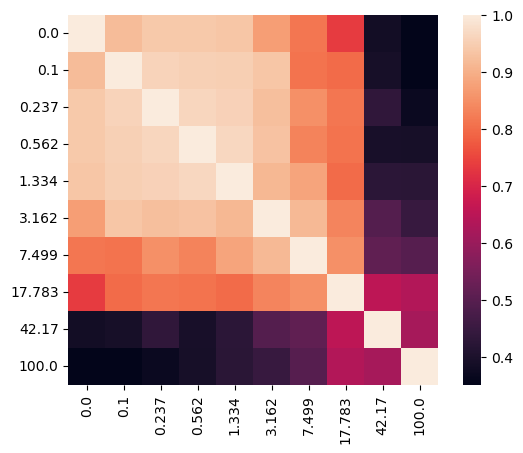

In [45]:
_lambda_list = [str(round(float(x), 3)) for x in sispca_auto.lambda_contrast_list]
_df = pd.DataFrame(
    sispca_auto.affinity_matrix, 
    columns=_lambda_list, 
    index=_lambda_list
)

import seaborn as sns
import matplotlib.pyplot as plt

sns.heatmap(_df, annot=False, fmt=".2f", square = True)
plt.show()

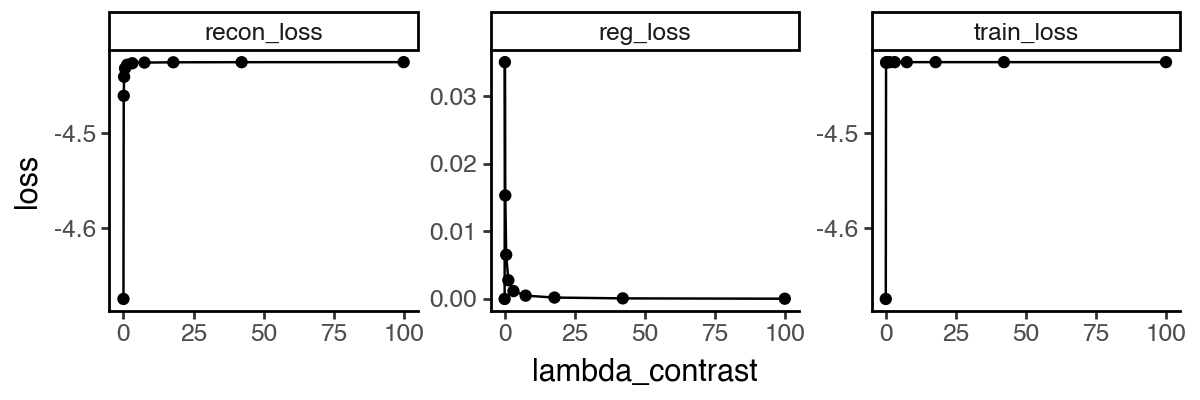

In [46]:
_df = pd.DataFrame(sispca_auto.final_loss[:]).melt(
    id_vars = 'lambda_contrast', var_name = 'loss_type', value_name = 'loss'
)

(
    ggplot(_df, aes(x = 'lambda_contrast', y = 'loss', group = 'loss_type')) + 
        facet_wrap('~loss_type', scales='free_y') +
        geom_line() + 
        geom_point() +
        theme_classic() + 
        theme(figure_size=(6,2))
)

From the above results, it appears that any non-zero `lambda_contrast` will give very similar results. We can further visualize the dynamics of the infection subspace by plotting the first two PCs, since its effective dimension is 2 (i.e. two groups).

In [47]:
_df = pd.concat([
    pd.DataFrame(
        {'lambda_contrast': l, 
         'PC_1': m.get_latent_representation()[:, 0], 
         'PC_2': m.get_latent_representation()[:, 1],
         'infected': adata.obs['infected'],
         'time': adata.obs['coarse_time']
        }
    )
    for l, m in zip(sispca_auto.lambda_contrast_list, sispca_auto.models)
])

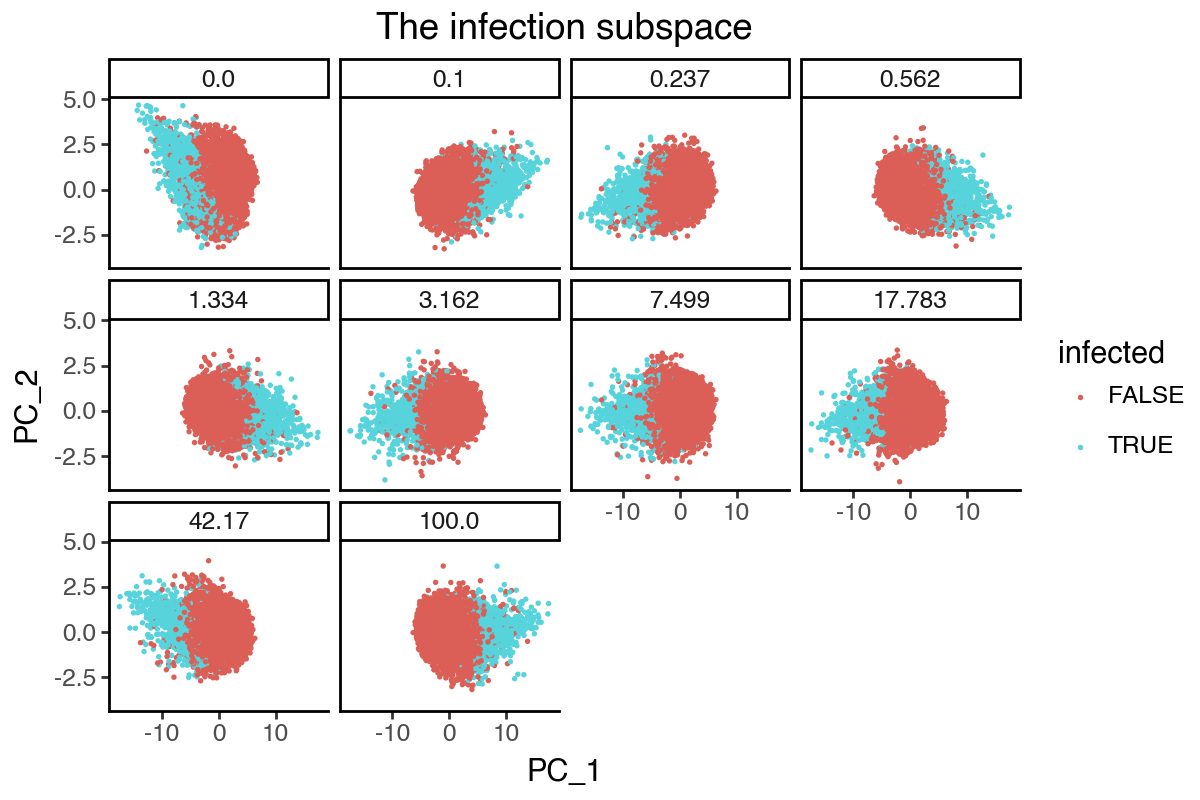

In [48]:

(
    ggplot(_df, aes(x = 'PC_1', y = 'PC_2', color = 'infected')) + 
        facet_wrap('~lambda_contrast', labeller=labeller(cols = lambda x: str(round(float(x), 3)))) +
        geom_point(size = 0.1) +
        labs(title = 'The infection subspace') +
        theme_classic() + 
        theme(
            figure_size=(6,4),
            plot_background = element_rect(fill = 'white'),
        )
)

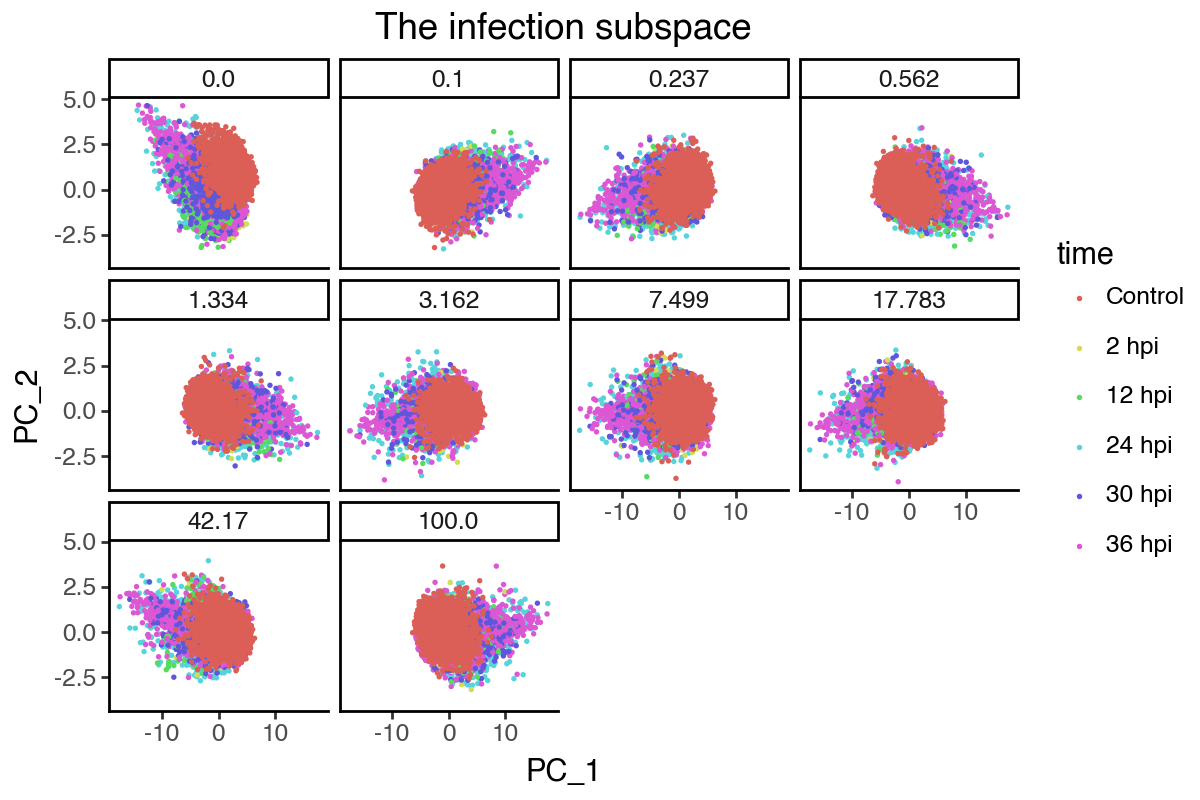

In [49]:
(
    ggplot(_df, aes(x = 'PC_1', y = 'PC_2', color = 'time')) + 
        facet_wrap('~lambda_contrast', labeller=labeller(cols = lambda x: str(round(float(x), 3)))) +
        geom_point(size = 0.1) +
        labs(title = 'The infection subspace') +
        theme_classic() + 
        theme(
            figure_size=(6,4),
            plot_background = element_rect(fill = 'white'),
        )
)

#### Robustness of gene importance ranking

Finally, we can check the robustness of the gene importance score by comparing the top genes associated with PC1 of the infection subspace across different `lambda_contrast` values. As we can see, models with non-zero disentanglement penalty overall share more than 80% of top genes, while the `sPCA` model with zero penalty has slightly less overlap with others.

In [50]:
u_list = [m.U.detach().numpy() for m in sispca_auto.models]

dist_list = []
for i in range(len(u_list)):
    for j in range(i, len(u_list)):
        _gene_idx_i = np.argsort(u_list[i][:, 0])
        _gene_idx_j = np.argsort(u_list[j][:, 0])
        
        dist_list.append({
            'lambda_1': sispca_auto.lambda_contrast_list[i],
            'lambda_2': sispca_auto.lambda_contrast_list[j],
            'size_pc1_top100': 0.5 * (max(
                len(np.intersect1d(_gene_idx_i[:100], _gene_idx_j[:100])),
                len(np.intersect1d(_gene_idx_i[:100], _gene_idx_j[-100:]))
            ) + max(
                len(np.intersect1d(_gene_idx_i[-100:], _gene_idx_j[:100])),
                len(np.intersect1d(_gene_idx_i[-100:], _gene_idx_j[-100:]))
            ))
        })

df_dist_gene = pd.DataFrame(dist_list)

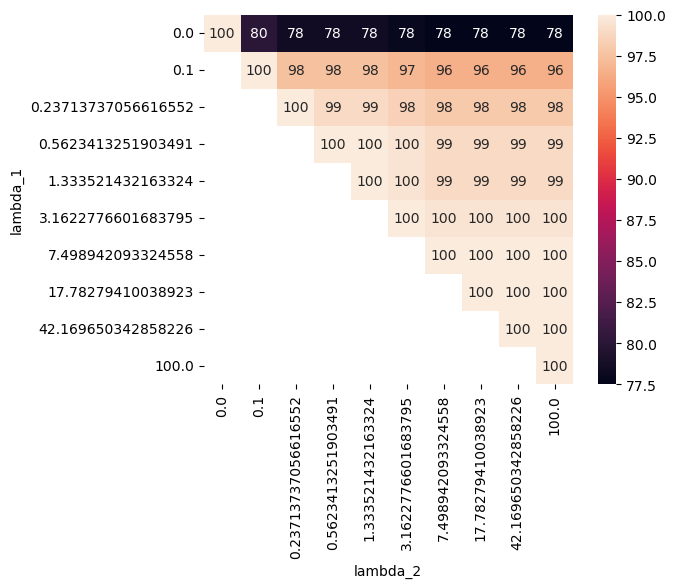

In [51]:
import seaborn as sns

_df = df_dist_gene.pivot(index = 'lambda_1', columns = 'lambda_2', values='size_pc1_top100')
sns.heatmap(_df, annot=True, fmt=".0f", square = True)
plt.show()